# Imports

In [1]:
import os, sys, time, glob, random, argparse
import wandb
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn
import time
import tqdm
import scipy.stats as stats
import matplotlib.pyplot as plt
import pickle
import pandas as pd

# XAutoDL 
from xautodl.config_utils import load_config, dict2config, configure2str
from xautodl.datasets import get_datasets, get_nas_search_loaders
from xautodl.procedures import (
    prepare_seed,
    prepare_logger,
    save_checkpoint,
    copy_checkpoint,
    get_optim_scheduler,
)
from xautodl.utils import get_model_infos, obtain_accuracy
from xautodl.log_utils import AverageMeter, time_string, convert_secs2time
from xautodl.models import get_search_spaces

# API
from nats_bench import create

# custom modules
from custom.tss_model import TinyNetwork
from xautodl.models.cell_searchs.genotypes import Structure
from ZeroShotProxy import *
from tss_utils import compute_vkdnw, plot_stats, get_stats, get_metrics, analyze_results, generate_accs, get_results_from_api, get_scores

# All

In [2]:
# scp 'tyblondr@login.rci.cvut.cz:~/PycharmProjects/VKDNW/NB201/ImageNet16*' plots_2710/

target = 'val_accs'
dataset = 'ImageNet16-120'
compute_graf = False
zero_cost_score_list = ['vkdnw', 'vkdnw_dim', 'vkdnw_chisquare', 'az_nas', 'jacov','gradsign', 'zico', 'zen', 'grad_norm', 'naswot', 'synflow', 'snip', 'grasp', 'te_nas']

In [3]:
run_dict = {
    'cifar10': {
        # same images
        #'nazderaze/VKDNW/n6n44keg': 1,
        #'nazderaze/VKDNW/6c1pv095': 2,
        #'nazderaze/VKDNW/45us11be': 3,
        #'nazderaze/VKDNW/rwp2qvkw': 4,
        #'nazderaze/VKDNW/6bsssh4z': 5,
        
        # different images
        #'nazderaze/VKDNW/7a8jm975' : -1 # testing (successfull)
        #'nazderaze/VKDNW/cixw6r9b': 1,
        #'nazderaze/VKDNW/1nikalf3': 2,
        #'nazderaze/VKDNW/r5l3qg12': 3,
        #'nazderaze/VKDNW/fq581h0d': 4,
        #'nazderaze/VKDNW/0yfzaxra': 5,
        
        # entropy
        #'nazderaze/VKDNW/87vy5rby': 1,
        #'nazderaze/VKDNW/8sd2hdws': 5,
        #'nazderaze/VKDNW/bh09isa0': 3,
        #'nazderaze/VKDNW/ei31s875': 4,
        #'nazderaze/VKDNW/koxirqt3': 2,
        
        # entropy all
        'nazderaze/VKDNW/6lcy0jqp': 1,
        'nazderaze/VKDNW/orl2me1l': 2,
        'nazderaze/VKDNW/y5n4lnsn': 3,
        'TODO': 4,
        'nazderaze/VKDNW/7gkdl3gl': 5,
    },
    'cifar100': {
        # same images
        #'nazderaze/VKDNW/qmq5vp3k': 1,
        #'nazderaze/VKDNW/31lrq6p7': 2,
        #'nazderaze/VKDNW/3qazc6po': 3,
        #'nazderaze/VKDNW/424twoyv': 4,
        #'nazderaze/VKDNW/783h4opf': 5,
        
        # different images
        #'nazderaze/VKDNW/n2m8i53l': 1,
        #'nazderaze/VKDNW/48xbnfdg': 2,
        #'nazderaze/VKDNW/f0czkx5u': 3,
        #'nazderaze/VKDNW/ldv3b1bh': 4,
        #'nazderaze/VKDNW/qwae4nqx': 5,
        
        # entropy
        #'nazderaze/VKDNW/lfnin2ui': 1,
        #'nazderaze/VKDNW/1cs8orlm': 4,
        #'nazderaze/VKDNW/4tep5lv0': 5,
        #'nazderaze/VKDNW/lqka0nwl': 2,
        #'nazderaze/VKDNW/mqrfyv7t': 3,
        
        # entropy all
        'TODO': 1,
        'TODO': 2,
        'TODO': 3,
        'TODO': 4,
        'TODO': 5,
    },
    'ImageNet16-120': {
        # same images
        #'nazderaze/VKDNW/ftg0tdsa': 1,
        #'nazderaze/VKDNW/vqf1ey6x': 2,
        #'nazderaze/VKDNW/v0a0m67q': 3,
        #'nazderaze/VKDNW/uiv37u18': 4,
        #'nazderaze/VKDNW/c1338vfg': 5,
        
        # different images
        #'nazderaze/VKDNW/55f1omxn': 1,
        #'nazderaze/VKDNW/amdcxrz7': 2,
        #'nazderaze/VKDNW/sl0rjhwh': 3,
        #'nazderaze/VKDNW/z2ph6iav': 4,
        #'nazderaze/VKDNW/ol9rwkeo': 5,
        
        # entropy
        # 'nazderaze/VKDNW/hwtw58ot': -1 # test
        #'nazderaze/VKDNW/u214u8p1': 4,
        #'nazderaze/VKDNW/bycu6ed3': 5,
        #'nazderaze/VKDNW/2ztcsos6': 3,
        #'nazderaze/VKDNW/kptcxbi2': 2,
        #'nazderaze/VKDNW/f9n7j83e': 1,
        
        'nazderaze/VKDNW/hrrxcexh': 1,
        'nazderaze/VKDNW/jwhy017w': 2,
        'nazderaze/VKDNW/82rycftz': 3,
        'nazderaze/VKDNW/bw6b93p9': 4,
        'nazderaze/VKDNW/ca423k7t': 5,
    }
}

In [4]:
api_nats = create('/mnt/personal/tyblondr/NATS-tss-v1_0-3ffb9-simple/', 'tss', fast_mode=True, verbose=False)

if os.path.exists(f"./tss_features_{dataset}.pickle"):
    archs = pd.read_pickle(f"./tss_features_{dataset}.pickle")
else:
    archs = generate_accs(api_nats, dataset=dataset)
    print(f'No. of generated archs: {archs.shape[0]}')
    archs.to_pickle(f"./tss_features_{dataset}.pickle")

In [5]:
""" TODO: testing results
api_wandb = wandb.Api()
run_1 = pd.DataFrame(api_wandb.run('nazderaze/VKDNW/f9n7j83e').scan_history()) # good results
run_2 = pd.DataFrame(api_wandb.run('nazderaze/VKDNW/hrrxcexh').scan_history()) # bad results
run_3 = pd.DataFrame(api_wandb.run('nazderaze/VKDNW/5nuh6hz7').scan_history()) # testing (last layers)

run_1.rename({'arch': 'net_str'}, axis=1, inplace=True)
run_2.rename({'arch': 'net_str'}, axis=1, inplace=True)
run_3.rename({'arch': 'net_str'}, axis=1, inplace=True)
    
run_1['rank'] = run_1[['vkdnw_dim', 'vkdnw_entropy']].apply(tuple, axis=1).rank(method='dense', ascending=True).astype(int)
run_2['rank'] = run_2[['vkdnw_dim', 'vkdnw_entropy']].apply(tuple, axis=1).rank(method='dense', ascending=True).astype(int)
run_3['rank'] = run_3[['vkdnw_dim', 'vkdnw_entropy']].apply(tuple, axis=1).rank(method='dense', ascending=True).astype(int)
run_1 = pd.merge(archs, run_1, on='net_str', how='inner')
run_2 = pd.merge(archs, run_2, on='net_str', how='inner')
run_3 = pd.merge(archs, run_3, on='net_str', how='inner')

run_3[[target, 'rank']].corr(method='kendall')
""" 

" TODO: testing results\napi_wandb = wandb.Api()\nrun_1 = pd.DataFrame(api_wandb.run('nazderaze/VKDNW/f9n7j83e').scan_history()) # good results\nrun_2 = pd.DataFrame(api_wandb.run('nazderaze/VKDNW/hrrxcexh').scan_history()) # bad results\nrun_3 = pd.DataFrame(api_wandb.run('nazderaze/VKDNW/5nuh6hz7').scan_history()) # testing (last layers)\n\nrun_1.rename({'arch': 'net_str'}, axis=1, inplace=True)\nrun_2.rename({'arch': 'net_str'}, axis=1, inplace=True)\nrun_3.rename({'arch': 'net_str'}, axis=1, inplace=True)\n    \nrun_1['rank'] = run_1[['vkdnw_dim', 'vkdnw_entropy']].apply(tuple, axis=1).rank(method='dense', ascending=True).astype(int)\nrun_2['rank'] = run_2[['vkdnw_dim', 'vkdnw_entropy']].apply(tuple, axis=1).rank(method='dense', ascending=True).astype(int)\nrun_3['rank'] = run_3[['vkdnw_dim', 'vkdnw_entropy']].apply(tuple, axis=1).rank(method='dense', ascending=True).astype(int)\nrun_1 = pd.merge(archs, run_1, on='net_str', how='inner')\nrun_2 = pd.merge(archs, run_2, on='net_str',

In [6]:
api_wandb = wandb.Api()

log = None
results = None
for run_id, seed in run_dict[dataset].items():
    
    run = pd.DataFrame(api_wandb.run(run_id).scan_history())
    run.rename({'arch': 'net_str'}, axis=1, inplace=True)
    
    run = pd.merge(archs, run, on='net_str', how='inner')
    if compute_graf:
        run = run.loc[run['net'].notnull(), :]  # keep only nets with features
        
    print(f'No. of archs for seed {seed} after filtering: {run.shape[0]}.')
    
    for col in run.columns:
        if col not in ['net_str', 'net']:
            run[col] = run[col].astype(float)
    
    if 'jacov' in run.columns:        
        run['jacov'] = run['jacov'].fillna(run['jacov'].min()).astype(float)

    df_scores = get_scores(run.copy(), compute_graf=compute_graf, zero_cost_score_list=zero_cost_score_list)
    df_scores['dataset'] = dataset
    df_scores['seed'] = seed
    if results is None:
        results = df_scores
    else:
        results = pd.concat([results, df_scores], ignore_index=True)
print(f'Total number of records: {results.shape[0]}')

No. of archs for seed 1 after filtering: 15625.
Running vkdnw
Running vkdnw_dim
Running vkdnw_chisquare
Running az_nas
Running jacov
Running gradsign
Running zico
Running zen
Running grad_norm
Running naswot
Running synflow
Running snip
Running grasp
Running te_nas
No. of archs for seed 2 after filtering: 15625.
Running vkdnw
Running vkdnw_dim
Running vkdnw_chisquare
Running az_nas
Running jacov
Running gradsign
Running zico
Running zen
Running grad_norm
Running naswot
Running synflow
Running snip
Running grasp
Running te_nas
No. of archs for seed 3 after filtering: 15625.
Running vkdnw
Running vkdnw_dim
Running vkdnw_chisquare
Running az_nas
Running jacov
Running gradsign
Running zico
Running zen
Running grad_norm
Running naswot
Running synflow
Running snip
Running grasp
Running te_nas
No. of archs for seed 4 after filtering: 15625.
Running vkdnw
Running vkdnw_dim
Running vkdnw_chisquare
Running az_nas
Running jacov
Running gradsign
Running zico
Running zen
Running grad_norm
Running n

In [7]:
log = None
for seed in results['seed'].unique():
    
    results_temp = results.loc[results['seed'] == seed, :].copy()
    for zero_cost_rank in [p for p in results_temp.columns if '_rank' in p]:
        results_temp[[zero_cost_rank]] = results_temp[[zero_cost_rank]].apply(lambda x: x.replace(-np.inf, x[x != -np.inf].min()))
        results_temp[[zero_cost_rank]] = results_temp[[zero_cost_rank]].apply(lambda x: x.replace(-np.nan, x[x != -np.inf].min()))
        results_temp[[zero_cost_rank]] = results_temp[[zero_cost_rank]].apply(lambda x: x.replace(np.inf, x[x != np.inf].max()))
        log_temp = pd.DataFrame(get_metrics(results_temp, pred_name=zero_cost_rank, show_plot=False))
        
        if log is None:
            log = log_temp.copy()
        else:
            log = pd.concat([log, log_temp.copy()], ignore_index=True)
            
        if seed == min(results['seed'].unique()):
            plot_stats(get_stats(results_temp, 'vkdnw_dim', target, zero_cost_rank), 'vkdnw_dim', target, zero_cost_rank, f'{dataset}_{str(compute_graf)}_{zero_cost_rank}')

log = log.groupby('pred_name', as_index=False).agg(['mean', 'std']).reset_index()
log['dataset'] = dataset
log['no_seeds'] = len(results['seed'].unique())
log['archs_filtered'] = str(compute_graf)
log

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

pred_name   kendall            spearman             pearson  \
                              mean       std      mean       std      mean   
0            az_nas_rank  0.693971  0.000579  0.875774  0.000511  0.890275   
1         grad_norm_rank  0.321996  0.000547  0.441009  0.000609  0.072154   
2          gradsign_rank -0.203772  0.001066 -0.265248  0.001492  0.075750   
3             grasp_rank  0.332883  0.003338  0.470609  0.004973 -0.001358   
4             jacov_rank  0.536495  0.001042  0.701123  0.001247  0.583427   
5            naswot_rank  0.582778  0.000095  0.768347  0.000150  0.813633   
6              snip_rank  0.402702  0.000380  0.539271  0.000581  0.143227   
7           synflow_rank  0.555346  0.000132  0.747074  0.000094  0.069203   
8            te_nas_rank  0.458964  0.001582  0.640796  0.001947  0.659923   
9   vkdnw_chisquare_rank -0.056763  0.001018 -0.075550  0.001161 -0.408049   
10       vkdnw_comb_rank  0.722915  0.000427  0.892964  0.000231  0.899033   
11        vkdnw_dim_rank  0.574273  0.000000  0.716298  0.000000  0.653620   
12        vkdnw_exp_rank  0.700191  0.000699  0.883770  0.000614  0.867373   
13       vkdnw_prog_rank  0.710167  0.000512  0.889615  0.000345  0.866033   
14            vkdnw_rank  0.605502  0.000257  0.795219  0.000251  0.736706   
15      vkdnw_train_rank  0.655267  0.000482  0.839523  0.000526  0.839497   
16              zen_rank  0.250367  0.000065  0.344212  0.000139  0.453846   
17             zico_rank  0.594088  0.000616  0.787196  0.000572  0.746865   

               auc_roc              auc_pr  ...      gain_exp  gain_log  \
         std      mean       std      mean  ...           std      mean   
0   0.000878  0.600093  0.000044  0.401171  ...  2.294762e-03  0.448785   
1   0.007039  0.552584  0.000084  0.367030  ...  5.155906e-02  0.242751   
2   0.000219  0.483286  0.000164  0.308456  ...  2.714335e-02  0.149843   
3   0.026443  0.553357  0.000504  0.368573  ...  4.902481e-02  0.280305   
4   0.009565  0.586904  0.000106  0.385485  ...  2.944338e-02  0.391747   
5   0.000066  0.590749  0.000024  0.394707  ...  8.974565e-03  0.446949   
6   0.008721  0.565028  0.000068  0.371461  ...  1.136746e-02  0.244623   
7   0.000525  0.587159  0.000013  0.391783  ...  2.323301e-02  0.430257   
8   0.001998  0.576283  0.000259  0.383463  ...  5.577117e-03  0.398047   
9   0.000413  0.486609  0.000123  0.309464  ...  1.787173e-12  0.008333   
10  0.000151  0.601605  0.000016  0.403001  ...  7.638229e-03  0.450107   
11  0.000000  0.576835  0.000000  0.389198  ...  0.000000e+00  0.451539   
12  0.000347  0.600347  0.000043  0.402283  ...  6.038390e-03  0.449302   
13  0.000280  0.600406  0.000030  0.402764  ...  6.913959e-03  0.446056   
14  0.000372  0.589631  0.000029  0.396365  ...  1.269460e-02  0.440731   
15  0.000869  0.595268  0.000074  0.396759  ...  4.100034e-03  0.414850   
16  0.000152  0.547240  0.000012  0.354471  ...  1.243010e-03  0.349237   
17  0.000074  0.591598  0.000070  0.395924  ...  3.874633e-03  0.428682   

                   acc_top1             acc_top50                \
             std       mean        std       mean           std   
0   3.155147e-03  45.573333   0.651108  44.625489  1.306672e-01   
1   1.875311e-02  18.450000  10.127342  30.262267  3.414554e-01   
2   1.911505e-02  15.115556   3.593391  15.023200  5.944192e-01   
3   1.684524e-02  12.051111  10.259637  31.211778  5.675724e-01   
4   9.620612e-03  36.297778   4.744361  38.489356  5.901763e-01   
5   1.841385e-03  37.108889   3.647275  44.556956  3.302530e-02   
6   1.444075e-02   0.833333   0.000000  31.415889  2.822876e-01   
7   5.265623e-03  40.782222   4.723337  42.065333  3.552714e-15   
8   3.153536e-03  39.218889   1.016360  39.774022  8.009706e-02   
9   2.339784e-12   0.833333   0.000000   0.833333  0.000000e+00   
10  3.046081e-03  44.364444   1.164771  44.639822  5.098018e-02   
11  0.000000e+00  35.477778   0.000000  44.297778  0.000000e+00   
12  2.770528e-0

vkdnw
expressivity
trainability
|nor_conv_1x1~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=1716
cifar10-valid  FLOP=157.21 M, Params=1.101 MB, latency=23.24 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.96%], valid : [loss = 0.472 & top1 = 90.49%]
cifar10        FLOP=157.21 M, Params=1.101 MB, latency=23.24 ms.
cifar10        train : [loss = 0.003 & top1 = 99.95%], test  : [loss = 0.299 & top1 = 93.65%]
cifar100       FLOP=157.21 M, Params=1.107 MB, latency=23.21 ms.
cifar100       train : [loss = 0.059 & top1 = 99.25%], valid : [loss = 1.380 & top1 = 69.08%], test : [loss = 1.367 & top1 = 69.35%]
ImageNet16-120 FLOP= 39.31 M, Params=1.109 MB, latency=21.52 ms.
ImageNet16-120 train : [loss = 1.486 & top1 = 59.67%], valid : [loss = 2.138 & top1 = 45.59%], test : [loss = 2.146 & top1 = 46.16%]
trainability: 0.691465502136454	0.8768383592917725	0.87683

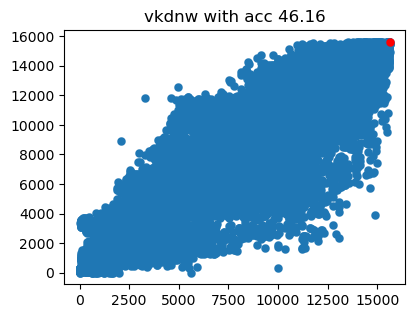

vkdnw_dim
|nor_conv_1x1~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_1x1~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=4317
cifar10-valid  FLOP= 31.38 M, Params=0.241 MB, latency=22.64 ms.
cifar10-valid  train : [loss = 0.072 & top1 = 98.13%], valid : [loss = 0.470 & top1 = 86.51%]
cifar10        FLOP= 31.38 M, Params=0.241 MB, latency=22.64 ms.
cifar10        train : [loss = 0.098 & top1 = 97.07%], test  : [loss = 0.340 & top1 = 89.37%]
cifar100       FLOP= 31.38 M, Params=0.247 MB, latency=21.61 ms.
cifar100       train : [loss = 0.586 & top1 = 84.28%], valid : [loss = 1.258 & top1 = 65.40%], test : [loss = 1.274 & top1 = 65.71%]
ImageNet16-120 FLOP=  7.85 M, Params=0.248 MB, latency=21.04 ms.
ImageNet16-120 train : [loss = 2.440 & top1 = 38.04%], valid : [loss = 2.561 & top1 = 35.32%], test : [loss = 2.569 & top1 = 35.48%]
vkdnw_dim: 0.5742734274039176	0.7162983384520083	0.7162983384520082	


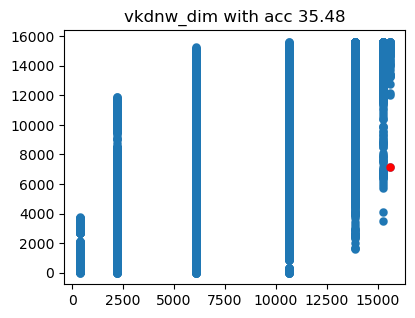

vkdnw_chisquare
|none~0|+|none~0|nor_conv_1x1~1|+|none~0|nor_conv_1x1~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=3341
cifar10-valid  FLOP= 19.58 M, Params=0.157 MB, latency=18.19 ms.
cifar10-valid  train : [loss = 2.302 & top1 = 10.29%], valid : [loss = 2.303 & top1 = 9.71%]
cifar10        FLOP= 19.58 M, Params=0.157 MB, latency=18.19 ms.
cifar10        train : [loss = 2.303 & top1 = 9.97%], test  : [loss = 2.303 & top1 = 10.00%]
cifar100       FLOP= 19.59 M, Params=0.163 MB, latency=17.08 ms.
cifar100       train : [loss = 4.605 & top1 = 1.00%], valid : [loss = 4.605 & top1 = 1.00%], test : [loss = 4.605 & top1 = 1.00%]
ImageNet16-120 FLOP=  4.90 M, Params=0.164 MB, latency=14.24 ms.
ImageNet16-120 train : [loss = 4.783 & top1 = 0.86%], valid : [loss = 4.792 & top1 = 0.83%], test : [loss = 4.792 & top1 = 0.83%]
vkdnw_chisquare: -0.05763167243756122	-0.07649753834818984	-0.07649753834818986	


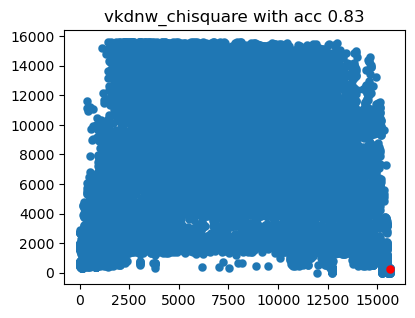

expressivity
progressivity
trainability
|nor_conv_3x3~0|+|skip_connect~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=4557
cifar10-valid  FLOP=153.27 M, Params=1.073 MB, latency=19.26 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.98%], valid : [loss = 0.493 & top1 = 90.44%]
cifar10        FLOP=153.27 M, Params=1.073 MB, latency=19.26 ms.
cifar10        train : [loss = 0.002 & top1 = 99.96%], test  : [loss = 0.306 & top1 = 93.75%]
cifar100       FLOP=153.28 M, Params=1.079 MB, latency=19.23 ms.
cifar100       train : [loss = 0.036 & top1 = 99.65%], valid : [loss = 1.331 & top1 = 70.44%], test : [loss = 1.291 & top1 = 71.71%]
ImageNet16-120 FLOP= 38.33 M, Params=1.081 MB, latency=20.21 ms.
ImageNet16-120 train : [loss = 1.414 & top1 = 61.50%], valid : [loss = 2.174 & top1 = 46.23%], test : [loss = 2.160 & top1 = 46.32%]
trainability: 0.693842243489055	0.8757116369875472

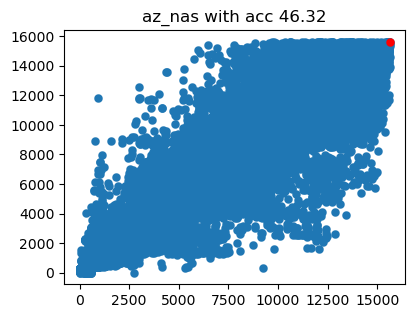

jacov
|nor_conv_1x1~0|+|nor_conv_1x1~0|skip_connect~1|+|skip_connect~0|nor_conv_1x1~1|none~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=2779
cifar10-valid  FLOP= 19.58 M, Params=0.157 MB, latency=17.13 ms.
cifar10-valid  train : [loss = 0.028 & top1 = 99.59%], valid : [loss = 0.447 & top1 = 87.72%]
cifar10        FLOP= 19.58 M, Params=0.157 MB, latency=17.13 ms.
cifar10        train : [loss = 0.056 & top1 = 98.65%], test  : [loss = 0.306 & top1 = 90.81%]
cifar100       FLOP= 19.59 M, Params=0.163 MB, latency=16.98 ms.
cifar100       train : [loss = 0.588 & top1 = 83.85%], valid : [loss = 1.233 & top1 = 66.79%], test : [loss = 1.208 & top1 = 66.77%]
ImageNet16-120 FLOP=  4.90 M, Params=0.164 MB, latency=16.45 ms.
ImageNet16-120 train : [loss = 2.292 & top1 = 41.23%], valid : [loss = 2.462 & top1 = 37.87%], test : [loss = 2.499 & top1 = 37.36%]
jacov: 0.5368876574728034	0.7013195738955451	0.7013195738955453	


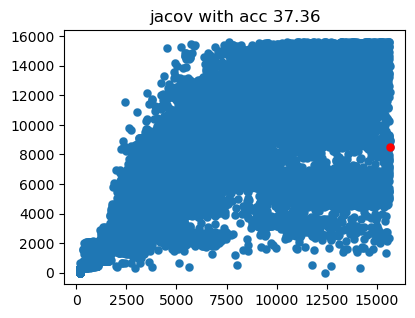

gradsign
|none~0|+|avg_pool_3x3~0|none~1|+|avg_pool_3x3~0|avg_pool_3x3~1|skip_connect~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=4934
cifar10-valid  FLOP=  7.78 M, Params=0.073 MB, latency=9.83 ms.
cifar10-valid  train : [loss = 0.661 & top1 = 76.72%], valid : [loss = 0.837 & top1 = 71.59%]
cifar10        FLOP=  7.78 M, Params=0.073 MB, latency=9.83 ms.
cifar10        train : [loss = 0.672 & top1 = 76.53%], test  : [loss = 0.765 & top1 = 73.49%]
cifar100       FLOP=  7.79 M, Params=0.079 MB, latency=9.75 ms.
cifar100       train : [loss = 1.957 & top1 = 48.06%], valid : [loss = 2.139 & top1 = 45.06%], test : [loss = 2.138 & top1 = 44.87%]
ImageNet16-120 FLOP=  1.95 M, Params=0.080 MB, latency=8.63 ms.
ImageNet16-120 train : [loss = 3.645 & top1 = 15.91%], valid : [loss = 3.670 & top1 = 15.82%], test : [loss = 3.698 & top1 = 14.68%]
gradsign: -0.20417240740166165	-0.2656954142933884	-0.26569541429338844	


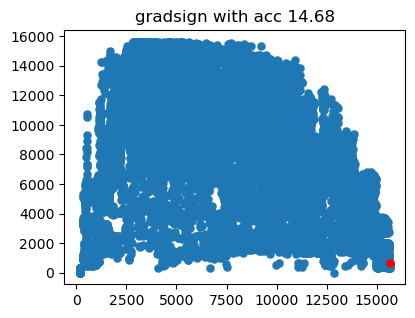

zico
|nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=1462
cifar10-valid  FLOP=220.12 M, Params=1.532 MB, latency=23.63 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.98%], valid : [loss = 0.491 & top1 = 90.20%]
cifar10        FLOP=220.12 M, Params=1.532 MB, latency=23.63 ms.
cifar10        train : [loss = 0.002 & top1 = 99.97%], test  : [loss = 0.296 & top1 = 93.76%]
cifar100       FLOP=220.13 M, Params=1.537 MB, latency=22.58 ms.
cifar100       train : [loss = 0.024 & top1 = 99.79%], valid : [loss = 1.365 & top1 = 70.71%], test : [loss = 1.354 & top1 = 71.11%]
ImageNet16-120 FLOP= 55.04 M, Params=1.539 MB, latency=22.16 ms.
ImageNet16-120 train : [loss = 1.863 & top1 = 50.60%], valid : [loss = 2.316 & top1 = 40.78%], test : [loss = 2.311 & top1 = 41.44%]
zico: 0.5943794897793059	0.7871967929994816	0.7871967929994819	


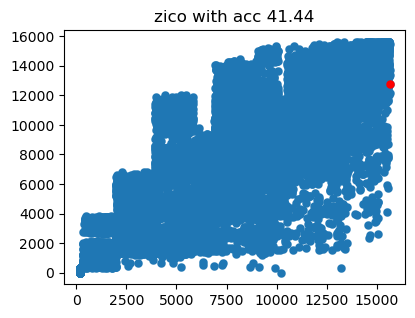

zen
|skip_connect~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|skip_connect~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=10319
cifar10-valid  FLOP=113.95 M, Params=0.802 MB, latency=15.94 ms.
cifar10-valid  train : [loss = 0.035 & top1 = 99.37%], valid : [loss = 0.486 & top1 = 87.34%]
cifar10        FLOP=113.95 M, Params=0.802 MB, latency=15.94 ms.
cifar10        train : [loss = 0.042 & top1 = 98.77%], test  : [loss = 0.368 & top1 = 90.65%]
cifar100       FLOP=113.96 M, Params=0.808 MB, latency=15.42 ms.
cifar100       train : [loss = 0.494 & top1 = 85.75%], valid : [loss = 1.211 & top1 = 67.20%], test : [loss = 1.196 & top1 = 68.10%]
ImageNet16-120 FLOP= 28.50 M, Params=0.810 MB, latency=12.93 ms.
ImageNet16-120 train : [loss = 2.132 & top1 = 44.57%], valid : [loss = 2.332 & top1 = 39.62%], test : [loss = 2.359 & top1 = 40.77%]
zen: 0.25036367185020236	0.3442969572702932	0.3442969572702933	


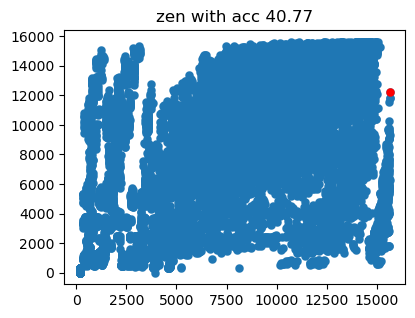

grad_norm
|nor_conv_1x1~0|+|none~0|nor_conv_3x3~1|+|none~0|none~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=15053
cifar10-valid  FLOP= 82.49 M, Params=0.587 MB, latency=17.72 ms.
cifar10-valid  train : [loss = 0.030 & top1 = 99.11%], valid : [loss = 0.605 & top1 = 86.56%]
cifar10        FLOP= 82.49 M, Params=0.587 MB, latency=17.72 ms.
cifar10        train : [loss = 0.077 & top1 = 97.47%], test  : [loss = 0.401 & top1 = 89.34%]
cifar100       FLOP= 82.50 M, Params=0.593 MB, latency=17.01 ms.
cifar100       train : [loss = 0.582 & top1 = 83.25%], valid : [loss = 1.461 & top1 = 61.72%], test : [loss = 1.445 & top1 = 62.98%]
ImageNet16-120 FLOP= 20.63 M, Params=0.595 MB, latency=21.33 ms.
ImageNet16-120 train : [loss = 3.052 & top1 = 24.45%], valid : [loss = 3.079 & top1 = 24.10%], test : [loss = 3.079 & top1 = 24.38%]
grad_norm: 0.32198179942873095	0.4407440921567639	0.4407440921567639	


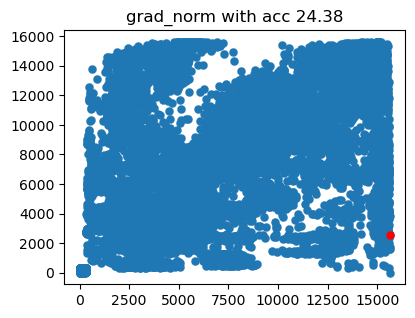

naswot
|nor_conv_1x1~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_1x1~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=4317
cifar10-valid  FLOP= 31.38 M, Params=0.241 MB, latency=22.64 ms.
cifar10-valid  train : [loss = 0.072 & top1 = 98.13%], valid : [loss = 0.470 & top1 = 86.51%]
cifar10        FLOP= 31.38 M, Params=0.241 MB, latency=22.64 ms.
cifar10        train : [loss = 0.098 & top1 = 97.07%], test  : [loss = 0.340 & top1 = 89.37%]
cifar100       FLOP= 31.38 M, Params=0.247 MB, latency=21.61 ms.
cifar100       train : [loss = 0.586 & top1 = 84.28%], valid : [loss = 1.258 & top1 = 65.40%], test : [loss = 1.274 & top1 = 65.71%]
ImageNet16-120 FLOP=  7.85 M, Params=0.248 MB, latency=21.04 ms.
ImageNet16-120 train : [loss = 2.440 & top1 = 38.04%], valid : [loss = 2.561 & top1 = 35.32%], test : [loss = 2.569 & top1 = 35.48%]
naswot: 0.5828439084367849	0.7683577474674375	0.7683577474674375	


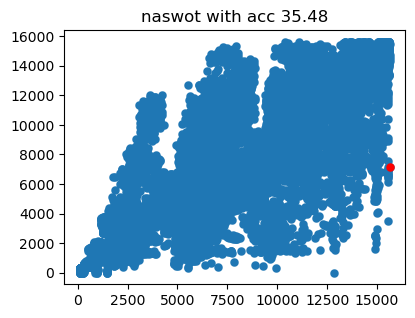

synflow
|nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=9930
cifar10-valid  FLOP=184.73 M, Params=1.289 MB, latency=20.59 ms.
cifar10-valid  train : [loss = 0.001 & top1 = 99.99%], valid : [loss = 0.424 & top1 = 91.55%]
cifar10        FLOP=184.73 M, Params=1.289 MB, latency=20.59 ms.
cifar10        train : [loss = 0.002 & top1 = 99.99%], test  : [loss = 0.278 & top1 = 94.36%]
cifar100       FLOP=184.74 M, Params=1.294 MB, latency=19.92 ms.
cifar100       train : [loss = 0.013 & top1 = 99.94%], valid : [loss = 1.259 & top1 = 73.49%], test : [loss = 1.237 & top1 = 73.51%]
ImageNet16-120 FLOP= 46.19 M, Params=1.296 MB, latency=20.57 ms.
ImageNet16-120 train : [loss = 0.952 & top1 = 73.23%], valid : [loss = 2.277 & top1 = 46.37%], test : [loss = 2.303 & top1 = 46.34%]
synflow: 0.5551482031011814	0.7469165458683151	0.7469165458683151	


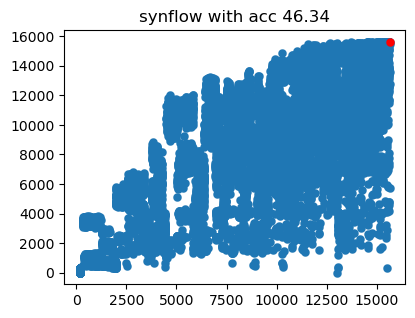

snip
|nor_conv_1x1~0|+|none~0|nor_conv_1x1~1|+|none~0|none~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=4992
cifar10-valid  FLOP= 19.58 M, Params=0.157 MB, latency=17.45 ms.
cifar10-valid  train : [loss = 0.389 & top1 = 86.72%], valid : [loss = 0.599 & top1 = 80.25%]
cifar10        FLOP= 19.58 M, Params=0.157 MB, latency=17.45 ms.
cifar10        train : [loss = 0.367 & top1 = 87.39%], test  : [loss = 0.483 & top1 = 83.82%]
cifar100       FLOP= 19.59 M, Params=0.163 MB, latency=16.30 ms.
cifar100       train : [loss = 1.712 & top1 = 53.34%], valid : [loss = 1.881 & top1 = 49.42%], test : [loss = 1.851 & top1 = 49.81%]
ImageNet16-120 FLOP=  4.90 M, Params=0.164 MB, latency=16.45 ms.
ImageNet16-120 train : [loss = 4.783 & top1 = 0.86%], valid : [loss = 4.792 & top1 = 0.83%], test : [loss = 4.792 & top1 = 0.83%]
snip: 0.40322796127554567	0.5400946193168286	0.5400946193168286	


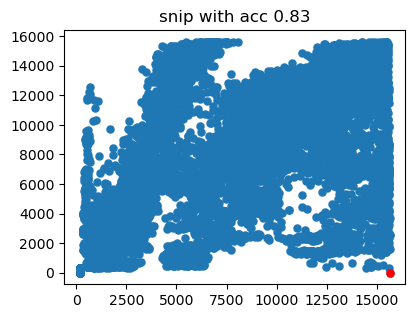

grasp
|nor_conv_3x3~0|+|none~0|nor_conv_3x3~1|+|none~0|none~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=13906
cifar10-valid  FLOP= 82.49 M, Params=0.587 MB, latency=18.58 ms.
cifar10-valid  train : [loss = 0.074 & top1 = 97.58%], valid : [loss = 0.594 & top1 = 85.17%]
cifar10        FLOP= 82.49 M, Params=0.587 MB, latency=18.58 ms.
cifar10        train : [loss = 0.059 & top1 = 98.10%], test  : [loss = 0.406 & top1 = 89.48%]
cifar100       FLOP= 82.50 M, Params=0.593 MB, latency=17.42 ms.
cifar100       train : [loss = 0.617 & top1 = 82.22%], valid : [loss = 1.468 & top1 = 61.82%], test : [loss = 1.447 & top1 = 62.01%]
ImageNet16-120 FLOP= 20.63 M, Params=0.595 MB, latency=17.78 ms.
ImageNet16-120 train : [loss = 3.222 & top1 = 21.41%], valid : [loss = 3.236 & top1 = 20.99%], test : [loss = 3.240 & top1 = 20.56%]
grasp: 0.33652003657404067	0.47583116577417295	0.475831165774173	


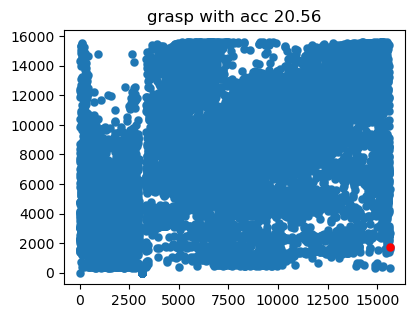

ntk
linear_region
|nor_conv_3x3~0|+|nor_conv_3x3~0|skip_connect~1|+|nor_conv_3x3~0|skip_connect~1|skip_connect~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=7966
cifar10-valid  FLOP=113.95 M, Params=0.802 MB, latency=15.66 ms.
cifar10-valid  train : [loss = 0.006 & top1 = 99.93%], valid : [loss = 0.501 & top1 = 89.13%]
cifar10        FLOP=113.95 M, Params=0.802 MB, latency=15.66 ms.
cifar10        train : [loss = 0.011 & top1 = 99.80%], test  : [loss = 0.330 & top1 = 92.00%]
cifar100       FLOP=113.96 M, Params=0.808 MB, latency=15.44 ms.
cifar100       train : [loss = 0.325 & top1 = 91.26%], valid : [loss = 1.296 & top1 = 66.22%], test : [loss = 1.265 & top1 = 67.34%]
ImageNet16-120 FLOP= 28.50 M, Params=0.810 MB, latency=15.36 ms.
ImageNet16-120 train : [loss = 2.109 & top1 = 45.03%], valid : [loss = 2.407 & top1 = 39.10%], test : [loss = 2.440 & top1 = 38.95%]
linear_region: 0.4565481126200976	0.6379185307186692	0.6379185307186693	

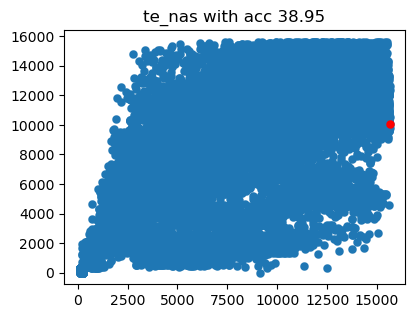

In [8]:
for zero_cost_score in zero_cost_score_list:
    results_temp = results.loc[results['seed'] == results['seed'].unique().min(), :].copy()
    analyze_results(api_nats, results_temp, zero_cost_score, target)

In [9]:
log_train = None
if not compute_graf:
    print('No graf prediction.')
else:
    print('Graf prediction.')
    
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    
    pred_lists = {
        'model_vkdnw': [p for p in results.columns if '_lambda_' in p] + ['vkdnw_chisquare', 'vkdnw_dim', 'flops'],
        'model_vkdnw+zs': [p for p in results.columns if '_lambda_' in p] + ['vkdnw_chisquare', 'vkdnw_dim', 'flops'] + ['expressivity', 'progressivity', 'trainability', 'jacov','gradsign', 'zico', 'zen', 'grad_norm', 'naswot', 'synflow', 'snip', 'grasp', 'ntk', 'linear_region'],
        'model_vkdnw+zs+graf': [p for p in results.columns if '_lambda_' in p] + ['vkdnw_chisquare', 'vkdnw_dim', 'flops'] + ['expressivity', 'progressivity', 'trainability', 'jacov','gradsign', 'zico', 'zen', 'grad_norm', 'naswot', 'synflow', 'snip', 'grasp', 'ntk', 'linear_region'] + [p for p in results.columns if 'op_' in p] + [p for p in results.columns if 'node_' in p]
    }
    
    for train_size in [32, 128, 1024]:
        for seed in results['seed'].unique():
            
            results_temp = results.loc[results['seed'] == seed, :].copy()
            results_temp = results_temp.apply(lambda x: x.replace(-np.inf, x[x != -np.inf].min()))
            results_temp = results_temp.apply(lambda x: x.replace(np.inf, x[x != np.inf].max()))
            for model_name, pred_list in pred_lists.items():
                
                train_df, test_df = train_test_split(results_temp, test_size=1 - (train_size / results_temp.shape[0]), random_state=seed)
                model = Pipeline([
                    ('scaler', StandardScaler()),           # Step 1: Standardize features
                    ('regressor', RandomForestRegressor(n_estimators=300))  # Step 2: Train RandomForestRegressor
                ])
                model.fit(train_df[pred_list], train_df[target])
                test_df['pred_' + model_name] = model.predict(test_df[pred_list])
                log_train_temp = pd.DataFrame(get_metrics(test_df, 'pred_' + model_name, show_plot=False))        
                log_train_temp['train_size'] = train_size
            
                if log_train is None:
                    log_train = log_train_temp.copy()
                else:
                    log_train = pd.concat([log_train, log_train_temp.copy()], ignore_index=True)
                    
                if seed == min(results['seed'].unique()):
                    plot_stats(get_stats(test_df, 'vkdnw_dim', target, 'pred_' + model_name), 'vkdnw_dim', target, model_name, f'{dataset}_{str(compute_graf)}_{model_name}_{train_size}')

    log_train = log_train.groupby(['pred_name', 'train_size'], as_index=False).agg(['mean', 'std']).reset_index()
    log_train['dataset'] = dataset
    log_train['no_seeds'] = len(results['seed'].unique())
    log_train['archs_filtered'] = str(compute_graf)
    log_train

No graf prediction.


In [10]:
if compute_graf:
    name_app = 'filtered'
    log_save = pd.concat([log, log_train], ignore_index=True)
else:
    name_app = 'unfiltered'
    log_save = log

log_save.to_csv(f'{dataset}_{name_app}_log.csv', index=False)

In [11]:
log_save[['pred_name', 'kendall']]

pred_name   kendall          
                              mean       std
0            az_nas_rank  0.693971  0.000579
1         grad_norm_rank  0.321996  0.000547
2          gradsign_rank -0.203772  0.001066
3             grasp_rank  0.332883  0.003338
4             jacov_rank  0.536495  0.001042
5            naswot_rank  0.582778  0.000095
6              snip_rank  0.402702  0.000380
7           synflow_rank  0.555346  0.000132
8            te_nas_rank  0.458964  0.001582
9   vkdnw_chisquare_rank -0.056763  0.001018
10       vkdnw_comb_rank  0.722915  0.000427
11        vkdnw_dim_rank  0.574273  0.000000
12        vkdnw_exp_rank  0.700191  0.000699
13       vkdnw_prog_rank  0.710167  0.000512
14            vkdnw_rank  0.605502  0.000257
15      vkdnw_train_rank  0.655267  0.000482
16              zen_rank  0.250367  0.000065
17             zico_rank  0.594088  0.000616

In [11]:
log_save[['pred_name', 'kendall']]

pred_name   kendall          
                              mean       std
0            az_nas_rank  0.693971  0.000579
1         grad_norm_rank  0.321996  0.000547
2          gradsign_rank -0.203772  0.001066
3             grasp_rank  0.332883  0.003338
4             jacov_rank  0.536495  0.001042
5            naswot_rank  0.582778  0.000095
6              snip_rank  0.402702  0.000380
7           synflow_rank  0.555346  0.000132
8            te_nas_rank  0.458964  0.001582
9   vkdnw_chisquare_rank -0.056763  0.001018
10       vkdnw_comb_rank  0.714619  0.000284
11        vkdnw_dim_rank  0.574273  0.000000
12    vkdnw_entropy_rank  0.605502  0.000257
13        vkdnw_exp_rank  0.679780  0.000790
14       vkdnw_prog_rank  0.692639  0.000466
15            vkdnw_rank  0.515688  0.000420
16      vkdnw_train_rank  0.639022  0.000655
17              zen_rank  0.250367  0.000065
18             zico_rank  0.594088  0.000616

# Fisher matrix size

- how does metrics evolve with changing params_grad_len
- data: ImageNet16-120 with batch size 32
- wandb runs: ImageNet16-120_B32_params_grad_len_X

In [4]:
# Import accs
api_nats = create('/mnt/personal/tyblondr/NATS-tss-v1_0-3ffb9-simple/', 'tss', fast_mode=True, verbose=False)
accs = generate_accs(api_nats, dataset='ImageNet16-120')

In [5]:
# Import data
api_wandb = wandb.Api()

results = None
for run_id, params_grad_len in {
    'nazderaze/VKDNW/hqc53sey': 8,
    'nazderaze/VKDNW/kkyfzf21': 16,
    'nazderaze/VKDNW/3bzcrn0t': 32, # compute time 45m 21s
    'nazderaze/VKDNW/3oj5wxoe': 64, # compute time 52m 39s
    'nazderaze/VKDNW/m29ccmi0': 128, # compute time 56m 57s
    'nazderaze/VKDNW/y9ib6om2': 256, # compute time 1h 3m 7s
}.items():
    run = pd.DataFrame(api_wandb.run(run_id).scan_history())
    run['params_grad_len'] = params_grad_len
    run = pd.merge(accs, run, on='arch', how='inner')
    print(f'Fisher matrix size: {params_grad_len}. No. of archs after filtering {run.shape[0]}.')
    
    if results is None:
        results = run
    else:
        results = pd.concat([results, run], ignore_index=True)

Fisher matrix size: 8. No. of archs after filtering 9445.
Fisher matrix size: 16. No. of archs after filtering 9445.
Fisher matrix size: 32. No. of archs after filtering 9445.
Fisher matrix size: 64. No. of archs after filtering 9445.
Fisher matrix size: 128. No. of archs after filtering 9445.
Fisher matrix size: 256. No. of archs after filtering 9445.


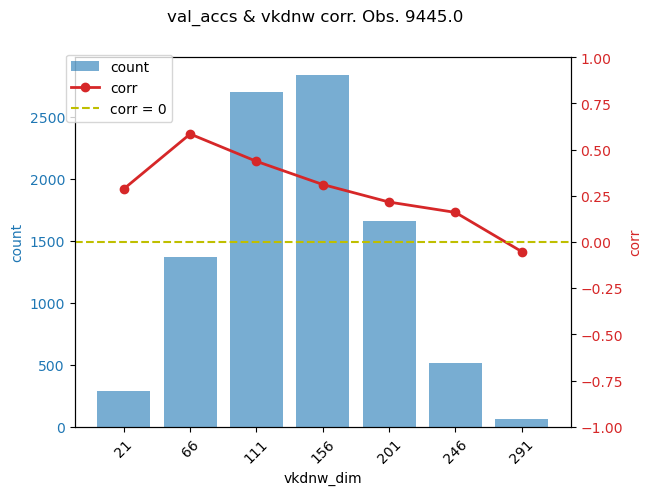

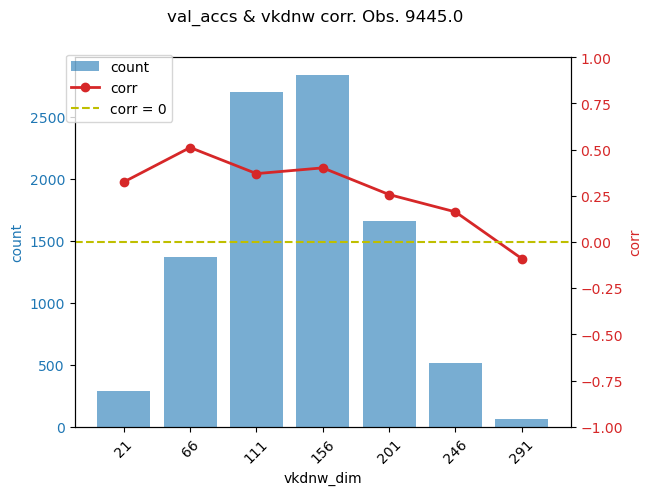

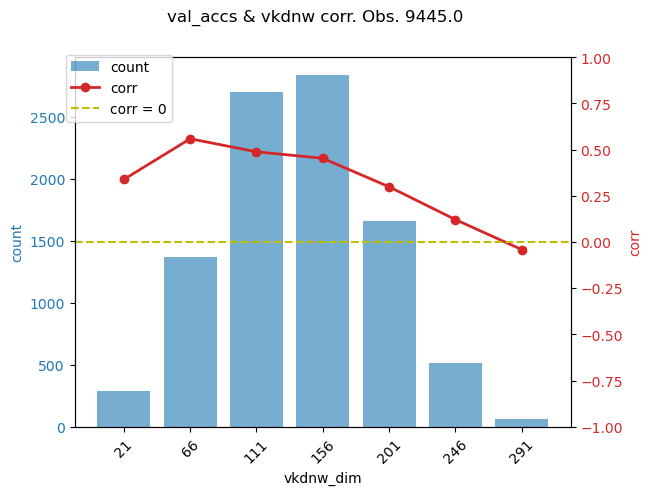

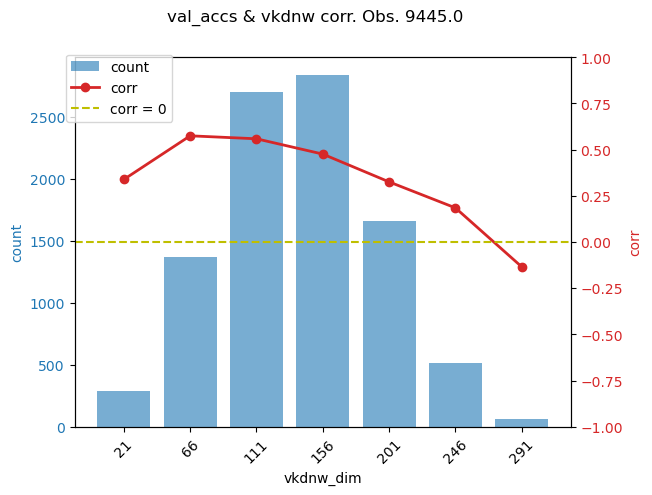

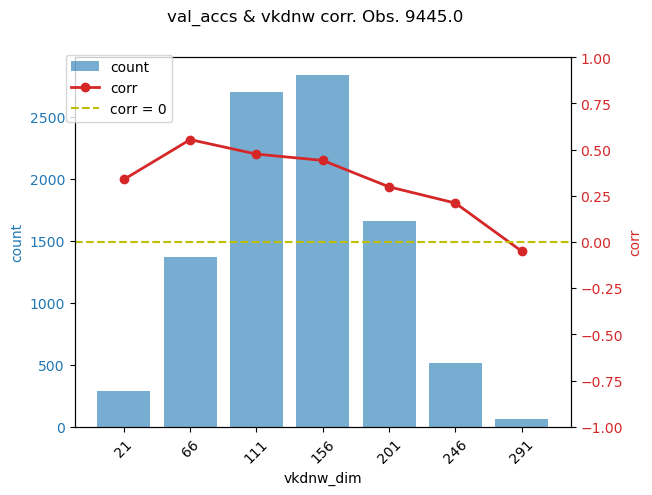

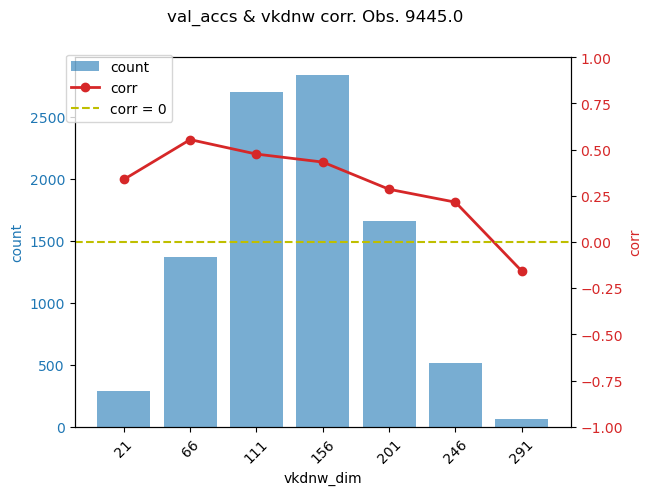

In [6]:
log = None
for params_grad_len in [8, 16, 32, 64, 128, 256]:
    results_temp = results.loc[results['params_grad_len']==params_grad_len].copy()
    results_temp['vkdnw'] = compute_vkdnw(results_temp)
    plot_stats(get_stats(results_temp, 'vkdnw_dim', target, 'vkdnw'), 'vkdnw_dim', target, 'vkdnw')
    log_temp = pd.DataFrame(get_metrics(results_temp, 'vkdnw', show_plot=False))
    log_temp['params_grad_len'] = params_grad_len
    
    if log is None:
        log = log_temp
    else:
        log = pd.concat([log, log_temp], ignore_index=True)

In [7]:
log

,pred_name,kendall,spearman,pearson,auc_roc,auc_pr,auc_pr10,gain_norm,gain_exp,gain_log,params_grad_len
0,vkdnw,0.630941,0.814720,0.742376,0.574150,0.406820,0.043423,0.928104,0.424796,0.443023,8
1,vkdnw,0.633412,0.818724,0.745830,0.574304,0.407154,0.043435,0.932731,0.437110,0.440193,16
2,vkdnw,0.649957,0.832984,0.756925,0.575469,0.407854,0.043451,0.937561,0.437972,0.441665,32
3,vkdnw,0.659148,0.839057,0.756658,0.575870,0.408206,0.043530,0.934535,0.444159,0.439626,64
4,vkdnw,0.648114,0.830015,0.739769,0.575000,0.407730,0.043550,0.941453,0.450301,0.446952,128
5,vkdnw,0.646909,0.828585,0.738657,0.574895,0.407557,0.043532,0.934713,0.437676,0.440637,256


Fisher matrix size: 8
vkdnw
|nor_conv_3x3~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=12117
cifar10-valid  FLOP=125.75 M, Params=0.886 MB, latency=23.68 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.97%], valid : [loss = 0.517 & top1 = 89.90%]
cifar10        FLOP=125.75 M, Params=0.886 MB, latency=23.68 ms.
cifar10        train : [loss = 0.003 & top1 = 99.95%], test  : [loss = 0.310 & top1 = 93.31%]
cifar100       FLOP=125.75 M, Params=0.892 MB, latency=21.02 ms.
cifar100       train : [loss = 0.059 & top1 = 99.19%], valid : [loss = 1.296 & top1 = 70.52%], test : [loss = 1.322 & top1 = 70.31%]
ImageNet16-120 FLOP= 31.44 M, Params=0.894 MB, latency=22.20 ms.
ImageNet16-120 train : [loss = 1.849 & top1 = 51.01%], valid : [loss = 2.258 & top1 = 42.33%], test : [loss = 2.274 & top1 = 42.03%]
vkdnw: 0.6309414339548626	0.814719826424962	0.814719826424961

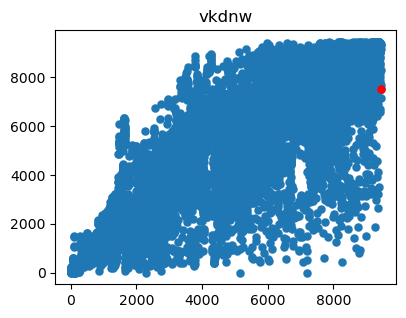

Fisher matrix size: 16
vkdnw
|nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=4681
cifar10-valid  FLOP=125.75 M, Params=0.886 MB, latency=23.35 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.97%], valid : [loss = 0.477 & top1 = 90.20%]
cifar10        FLOP=125.75 M, Params=0.886 MB, latency=23.35 ms.
cifar10        train : [loss = 0.003 & top1 = 99.96%], test  : [loss = 0.294 & top1 = 93.61%]
cifar100       FLOP=125.75 M, Params=0.892 MB, latency=21.45 ms.
cifar100       train : [loss = 0.063 & top1 = 99.15%], valid : [loss = 1.320 & top1 = 69.75%], test : [loss = 1.332 & top1 = 69.82%]
ImageNet16-120 FLOP= 31.44 M, Params=0.894 MB, latency=22.26 ms.
ImageNet16-120 train : [loss = 1.634 & top1 = 56.07%], valid : [loss = 2.155 & top1 = 44.11%], test : [loss = 2.145 & top1 = 45.27%]
vkdnw: 0.6334122048573143	0.818723613571873	0.818723613571873

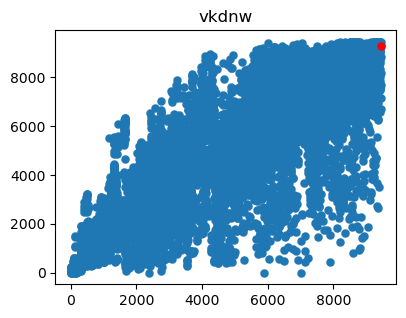

Fisher matrix size: 32
vkdnw
|nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=7294
cifar10-valid  FLOP=157.21 M, Params=1.101 MB, latency=23.10 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.98%], valid : [loss = 0.508 & top1 = 89.98%]
cifar10        FLOP=157.21 M, Params=1.101 MB, latency=23.10 ms.
cifar10        train : [loss = 0.003 & top1 = 99.97%], test  : [loss = 0.308 & top1 = 93.42%]
cifar100       FLOP=157.21 M, Params=1.107 MB, latency=23.04 ms.
cifar100       train : [loss = 0.037 & top1 = 99.62%], valid : [loss = 1.320 & top1 = 71.02%], test : [loss = 1.336 & top1 = 71.03%]
ImageNet16-120 FLOP= 39.31 M, Params=1.109 MB, latency=19.37 ms.
ImageNet16-120 train : [loss = 1.857 & top1 = 50.71%], valid : [loss = 2.292 & top1 = 41.10%], test : [loss = 2.292 & top1 = 42.22%]
vkdnw: 0.6499571265397174	0.8329839250376998	0.8329839250377	

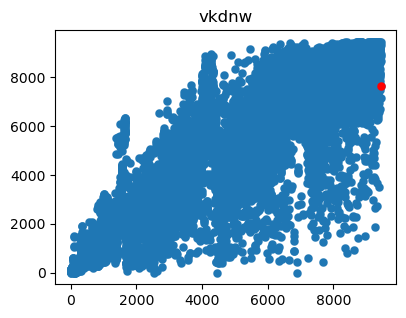

Fisher matrix size: 64
vkdnw
|nor_conv_1x1~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_3x3~0|nor_conv_1x1~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=7442
cifar10-valid  FLOP=125.75 M, Params=0.886 MB, latency=23.12 ms.
cifar10-valid  train : [loss = 0.003 & top1 = 99.97%], valid : [loss = 0.492 & top1 = 89.85%]
cifar10        FLOP=125.75 M, Params=0.886 MB, latency=23.12 ms.
cifar10        train : [loss = 0.004 & top1 = 99.94%], test  : [loss = 0.305 & top1 = 93.10%]
cifar100       FLOP=125.75 M, Params=0.892 MB, latency=21.38 ms.
cifar100       train : [loss = 0.080 & top1 = 98.81%], valid : [loss = 1.276 & top1 = 70.38%], test : [loss = 1.290 & top1 = 70.34%]
ImageNet16-120 FLOP= 31.44 M, Params=0.894 MB, latency=21.80 ms.
ImageNet16-120 train : [loss = 1.597 & top1 = 56.99%], valid : [loss = 2.159 & top1 = 44.28%], test : [loss = 2.167 & top1 = 45.24%]
vkdnw: 0.6591479349612106	0.8390568795013581	0.83905687950135

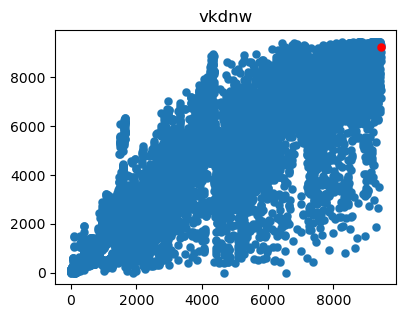

Fisher matrix size: 128
vkdnw
|nor_conv_1x1~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_1x1~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=12598
cifar10-valid  FLOP=125.75 M, Params=0.886 MB, latency=21.38 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.97%], valid : [loss = 0.487 & top1 = 90.30%]
cifar10        FLOP=125.75 M, Params=0.886 MB, latency=21.38 ms.
cifar10        train : [loss = 0.004 & top1 = 99.93%], test  : [loss = 0.308 & top1 = 93.32%]
cifar100       FLOP=125.75 M, Params=0.892 MB, latency=19.63 ms.
cifar100       train : [loss = 0.071 & top1 = 99.00%], valid : [loss = 1.307 & top1 = 70.32%], test : [loss = 1.317 & top1 = 70.02%]
ImageNet16-120 FLOP= 31.44 M, Params=0.894 MB, latency=18.13 ms.
ImageNet16-120 train : [loss = 1.550 & top1 = 58.07%], valid : [loss = 2.128 & top1 = 45.32%], test : [loss = 2.163 & top1 = 44.95%]
vkdnw: 0.6481142262918091	0.830015164089027	0.8300151640890

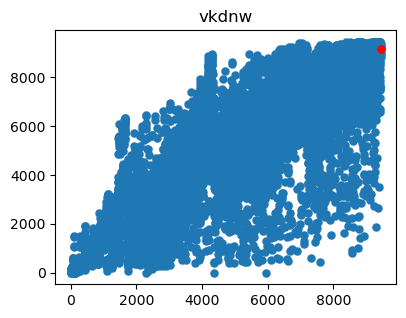

Fisher matrix size: 256
vkdnw
|nor_conv_1x1~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_1x1~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=12598
cifar10-valid  FLOP=125.75 M, Params=0.886 MB, latency=21.38 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.97%], valid : [loss = 0.487 & top1 = 90.30%]
cifar10        FLOP=125.75 M, Params=0.886 MB, latency=21.38 ms.
cifar10        train : [loss = 0.004 & top1 = 99.93%], test  : [loss = 0.308 & top1 = 93.32%]
cifar100       FLOP=125.75 M, Params=0.892 MB, latency=19.63 ms.
cifar100       train : [loss = 0.071 & top1 = 99.00%], valid : [loss = 1.307 & top1 = 70.32%], test : [loss = 1.317 & top1 = 70.02%]
ImageNet16-120 FLOP= 31.44 M, Params=0.894 MB, latency=18.13 ms.
ImageNet16-120 train : [loss = 1.550 & top1 = 58.07%], valid : [loss = 2.128 & top1 = 45.32%], test : [loss = 2.163 & top1 = 44.95%]
vkdnw: 0.6469087665593058	0.828585268188039	0.8285852681880

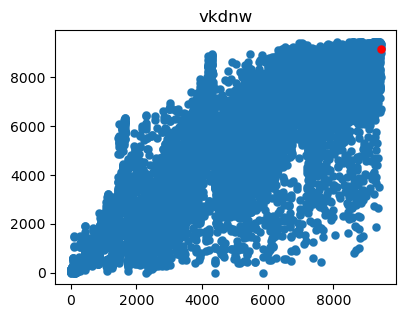

In [8]:
for params_grad_len in [8, 16, 32, 64, 128, 256]:
    results_temp = results.loc[results['params_grad_len']==params_grad_len].copy()
    print(f'Fisher matrix size: {params_grad_len}')
    analyze_results(api_nats, results_temp, 'vkdnw', target)

# Batch size

- how does metrics evolve with changing batch_size
- data: cifar10 with batch size 32 and real input whenever possible
- wandb runs: cifar10_BX_real_input

In [2]:
# Import accs
api_nats = create('/mnt/personal/tyblondr/NATS-tss-v1_0-3ffb9-simple/', 'tss', fast_mode=True, verbose=False)
accs = generate_accs(api_nats, dataset='ImageNet16-120', filter=False)
accs

StopIteration: 

StopIteration: 

In [42]:
import pickle
with open("./tss_all_arch.pickle", "rb") as fp:
    all_archs = pickle.load(fp)
        
api_valid_accs, api_flops, api_params = [], [], []
for a in all_archs:
    try:
        valid_acc, flops, params = get_results_from_api(api_nats, a, 'ImageNet16-120')
        api_valid_accs.append(valid_acc)
        api_flops.append(flops)
        api_params.append(params)
    except Exception as e:
        print(e)
        
accs = pd.DataFrame({
    'arch': [a.tostr() for a in all_archs],
    'val_accs': api_valid_accs,
    'flops': api_flops,
    'params': api_params,
})

In [77]:
# Import data
api_wandb = wandb.Api()

results = None
for run_id, batch_size in {
    #'nazderaze/VKDNW/9d14s94e': 16,
    #'nazderaze/VKDNW/cmic3xuh': 32,
    #'nazderaze/VKDNW/giukshg3': 64,
    #'nazderaze/VKDNW/gvzf6mwl': 128,
    'nazderaze/VKDNW/v8buuof4': 32 #imagenet rand
    #'nazderaze/VKDNW/kwuhsrer': 32 # imagtnet real
}.items():
    run = pd.DataFrame(api_wandb.run(run_id).scan_history())
    run['batch_size'] = batch_size
    run = pd.merge(accs, run, on='arch', how='left')
    print(f'Batch size: {batch_size}. No. of archs after filtering {run.shape[0]}.')
    
    if results is None:
        results = run
    else:
        results = pd.concat([results, run], ignore_index=True)

Batch size: 32. No. of archs after filtering 15625.


In [78]:
for col in results.columns:
    if col != 'arch':
        results[col] = results[col].astype(float)

In [79]:
results.loc[results['jacov'].isnull(), 'jacov'] = results['jacov'].min()

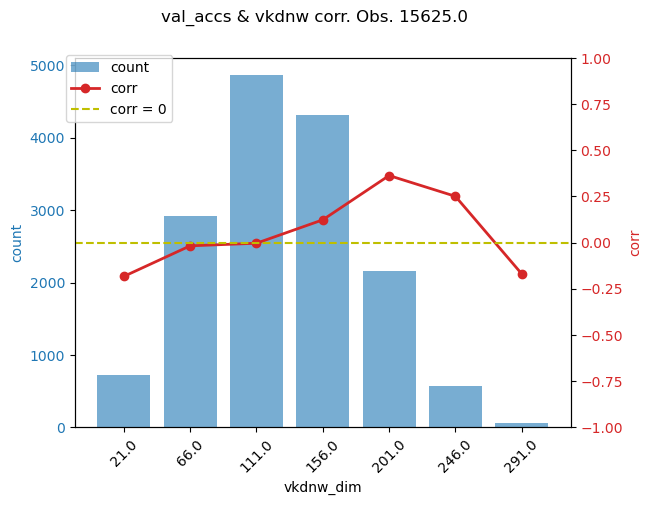

In [80]:
log = None
for batch_size in results['batch_size'].unique():
    results_temp = results.loc[results['batch_size']==batch_size].copy()
    
    results_temp['vkdnw'] = compute_vkdnw(results_temp)
    plot_stats(get_stats(results_temp, 'vkdnw_dim', target, 'vkdnw'), 'vkdnw_dim', target, 'vkdnw')
    log_vkdnw = pd.DataFrame(get_metrics(results_temp, 'vkdnw', show_plot=False))
    log_vkdnw['batch_size'] = batch_size
    
    results_temp['vkdnw_flops'] = results_temp['vkdnw'].rank().apply(np.log) * results_temp['flops'].rank().apply(np.log)
    log_flops = pd.DataFrame(get_metrics(results_temp, 'vkdnw_flops', show_plot=False))
    log_flops['batch_size'] = batch_size
    
    results_temp['vkdnw_exp'] =  results_temp['vkdnw'].rank().apply(np.log)+results_temp['progressivity'].astype(float).rank().apply(np.log)+results_temp['trainability'].astype(float).rank().apply(np.log)+results_temp['flops'].rank().apply(np.log)
    log_exp = pd.DataFrame(get_metrics(results_temp, 'vkdnw_exp', show_plot=False))
    log_exp['batch_size'] = batch_size
    
    results_temp['vkdnw_prog'] =  results_temp['expressivity'].astype(float).rank().apply(np.log)+results_temp['vkdnw'].rank().apply(np.log)+results_temp['trainability'].astype(float).rank().apply(np.log)+results_temp['flops'].rank().apply(np.log)
    log_prog = pd.DataFrame(get_metrics(results_temp, 'vkdnw_prog', show_plot=False))
    log_prog['batch_size'] = batch_size
    
    results_temp['vkdnw_trai'] =  results_temp['expressivity'].astype(float).rank().apply(np.log)+results_temp['progressivity'].astype(float).rank().apply(np.log)+results_temp['vkdnw'].rank().apply(np.log)+results_temp['flops'].rank().apply(np.log)    
    log_trai = pd.DataFrame(get_metrics(results_temp, 'vkdnw_trai', show_plot=False))
    log_trai['batch_size'] = batch_size
    
    results_temp['az_nas'] = results_temp['expressivity'].astype(float).rank().apply(np.log)+results_temp['progressivity'].astype(float).rank().apply(np.log)+results_temp['trainability'].astype(float).rank().apply(np.log)+results_temp['flops'].rank().apply(np.log)
    log_az = pd.DataFrame(get_metrics(results_temp, 'az_nas', show_plot=False))
    log_az['batch_size'] = batch_size
    
    if log is None:
        log = pd.concat([log_vkdnw, log_flops, log_exp, log_prog, log_trai, log_az], ignore_index=True)
    else:
        log = pd.concat([log, log_vkdnw, log_flops, log_exp, log_prog, log_trai, log_az], ignore_index=True)
        
    for pred_name in ['gradsign', 'zico', 'zen','naswot','synflow','snip','grasp', 'zen', 'jacov']:
        results_temp[pred_name] = results_temp[pred_name].astype(float).rank()
        log_temp = pd.DataFrame(get_metrics(results_temp, pred_name, show_plot=False))
        log_temp['batch_size'] = batch_size
        log = pd.concat([log, log_temp], ignore_index=True)

In [81]:
# IN rand
log

,pred_name,kendall,spearman,pearson,auc_roc,auc_pr,auc_pr10,gain_norm,gain_exp,gain_log,batch_size
0,vkdnw,0.519499,0.708751,0.623443,0.579266,0.391545,0.043254,0.931568,0.435225,0.436227,32.0
1,vkdnw_flops,0.541603,0.734992,0.679512,0.580549,0.391090,0.042643,0.912855,0.415094,0.431138,32.0
2,vkdnw_exp,0.667432,0.859745,0.845288,0.597910,0.400512,0.043717,0.954597,0.440412,0.447207,32.0
3,vkdnw_prog,0.679080,0.867631,0.845046,0.598112,0.400932,0.043724,0.950947,0.439465,0.445697,32.0
4,vkdnw_trai,0.630195,0.818701,0.814508,0.592500,0.395378,0.042155,0.906371,0.410229,0.421871,32.0
5,az_nas,0.671773,0.858802,0.874021,0.598280,0.399595,0.043268,0.947654,0.443887,0.439196,32.0
6,gradsign,-0.173231,-0.228196,-0.108086,0.486695,0.310728,0.022074,0.342155,0.161128,0.161139,32.0
7,zico,0.602476,0.793496,0.750188,0.592347,0.396218,0.042855,0.919770,0.426090,0.427395,32.0
8,zen,0.260149,0.358017,0.396907,0.548859,0.354905,0.031651,0.784693,0.398590,0.346656,32.0
9,naswot,0.611091,0.792200,0.752459,0.592627,0.395713,0.042646,0.926666,0.396220,0.447590,32.0


In [76]:
# IN real
log

,pred_name,kendall,spearman,pearson,auc_roc,auc_pr,auc_pr10,gain_norm,gain_exp,gain_log,batch_size
0,vkdnw,0.515595,0.706100,0.636677,0.578943,0.391376,0.043260,0.931105,0.429002,0.439398,32.0
1,vkdnw_flops,0.540000,0.734071,0.677375,0.580396,0.391063,0.042644,0.916300,0.423507,0.423254,32.0
2,vkdnw_exp,0.610242,0.807044,0.815197,0.593805,0.397027,0.043350,0.947305,0.436001,0.447023,32.0
3,vkdnw_prog,0.660864,0.852287,0.821171,0.596385,0.400014,0.043728,0.947962,0.435771,0.443246,32.0
4,vkdnw_trai,0.556295,0.748022,0.760586,0.586181,0.391491,0.042257,0.919092,0.418304,0.441849,32.0
5,az_nas,0.607677,0.803046,0.835856,0.593955,0.396114,0.042911,0.940787,0.433633,0.441923,32.0
6,gradsign,-0.177431,-0.232116,-0.111808,0.486236,0.309664,0.021206,0.313275,0.146142,0.153826,32.0
7,zico,0.599894,0.792333,0.748645,0.592158,0.396177,0.042872,0.918095,0.425116,0.432898,32.0
8,zen,0.226680,0.316603,0.369193,0.545447,0.352188,0.031487,0.799081,0.393779,0.381852,32.0
9,naswot,0.593334,0.776978,0.737279,0.590759,0.394664,0.042646,0.927265,0.400891,0.446908,32.0


In [45]:
# IN rand
log

,pred_name,kendall,spearman,pearson,auc_roc,auc_pr,auc_pr10,gain_norm,gain_exp,gain_log,batch_size
0,vkdnw,0.519499,0.708751,0.623443,0.579266,0.391545,0.043254,0.931568,0.435225,0.436227,32
1,vkdnw_flops,0.541603,0.734992,0.679512,0.580549,0.391090,0.042643,0.912855,0.415094,0.431138,32
2,vkdnw_exp,0.667432,0.859745,0.845288,0.597910,0.400512,0.043717,0.954597,0.440412,0.447207,32
3,vkdnw_prog,0.679080,0.867631,0.845046,0.598112,0.400932,0.043724,0.950947,0.439465,0.445697,32
4,vkdnw_trai,0.630195,0.818701,0.814508,0.592500,0.395378,0.042155,0.906371,0.410229,0.421871,32
5,az_nas,0.671773,0.858802,0.874021,0.598280,0.399595,0.043268,0.947654,0.443887,0.439196,32


In [25]:
# real
log

,pred_name,kendall,spearman,pearson,auc_roc,auc_pr,auc_pr10,gain_norm,gain_exp,gain_log,batch_size
0,vkdnw,0.611147,0.803146,0.758054,0.572503,0.406610,0.043460,0.931105,0.429002,0.439398,32
1,vkdnw_flops,0.615883,0.806525,0.824650,0.572486,0.405637,0.042880,0.916202,0.423446,0.423392,32
2,vkdnw_exp,0.620683,0.812089,0.859026,0.574967,0.407072,0.043798,0.950372,0.437601,0.444191,32
3,vkdnw_prog,0.695918,0.874842,0.884362,0.578658,0.410327,0.044066,0.944587,0.436931,0.445379,32
4,vkdnw_trai,0.580295,0.764877,0.808779,0.569467,0.403002,0.042934,0.922635,0.417245,0.437343,32
5,az_nas,0.592456,0.787018,0.822305,0.572652,0.405563,0.043557,0.941073,0.433381,0.441813,32


In [22]:
# rand
log

,pred_name,kendall,spearman,pearson,auc_roc,auc_pr,auc_pr10,gain_norm,gain_exp,gain_log,batch_size
0,vkdnw,0.646908,0.828585,0.738657,0.574895,0.407554,0.043529,0.931568,0.435225,0.436227,32
1,vkdnw_flops,0.631451,0.816308,0.840885,0.573524,0.405936,0.042817,0.912855,0.415094,0.431138,32
2,vkdnw_exp,0.664144,0.851997,0.875792,0.577418,0.409307,0.044041,0.952766,0.438495,0.450524,32
3,vkdnw_prog,0.703325,0.879728,0.898475,0.579363,0.410573,0.044070,0.950808,0.439424,0.445860,32
4,vkdnw_trai,0.645956,0.825972,0.841372,0.573794,0.405503,0.042530,0.918109,0.411636,0.427104,32
5,az_nas,0.643782,0.835676,0.843053,0.575671,0.408022,0.043750,0.948355,0.443259,0.447419,32


Batch size: 32
expressivity
progressivity
trainability
|nor_conv_3x3~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=6022
cifar10-valid  FLOP=121.82 M, Params=0.858 MB, latency=20.11 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.98%], valid : [loss = 0.489 & top1 = 90.16%]
cifar10        FLOP=121.82 M, Params=0.858 MB, latency=20.11 ms.
cifar10        train : [loss = 0.003 & top1 = 99.95%], test  : [loss = 0.301 & top1 = 93.60%]
cifar100       FLOP=121.82 M, Params=0.864 MB, latency=19.01 ms.
cifar100       train : [loss = 0.055 & top1 = 99.33%], valid : [loss = 1.296 & top1 = 70.46%], test : [loss = 1.286 & top1 = 70.77%]
ImageNet16-120 FLOP= 30.46 M, Params=0.866 MB, latency=20.66 ms.
ImageNet16-120 train : [loss = 1.619 & top1 = 56.44%], valid : [loss = 2.163 & top1 = 44.27%], test : [loss = 2.197 & top1 = 44.14%]
AZ-NAS: 0.671772514656878	0.8588018

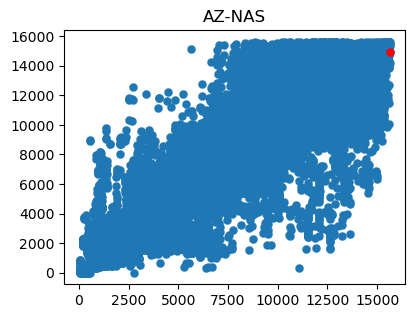

In [83]:
for batch_size in [32]:
    results_temp = results.loc[results['batch_size']==batch_size].copy()
    print(f'Batch size: {batch_size}')
    analyze_results(api_nats, results_temp, 'az_nas', target)

In [10]:
results_temp.head()

,arch,val_accs,flops,params,_timestamp,vkdnw_lambda_1,vkdnw_lambda_2,vkdnw_lambda_6,jacov,vkdnw_lambda_8,...,trainability,grasp,grad_norm,naswot,_runtime,vkdnw_lambda_3,zen,zico,vkdnw_lambda_5,batch_size
0,|avg_pool_3x3~0|+|skip_connect~0|none~1|+|nor_...,88.916667,15.64737,0.129306,1.729556e+09,2.627798e-05,8.005195e-05,43.356880,-16.928594,1401.476685,...,-0.155076,1.782674,3.093219,192.557599,48633.014337,0.080949,95.459938,343.456662,7.197623,16
1,|nor_conv_3x3~0|+|avg_pool_3x3~0|skip_connect~...,93.580000,82.49409,0.587386,1.729552e+09,2.448007e-02,2.796511e+00,1304.875732,-16.112389,71318.585938,...,-0.113689,1.677209,2.473265,198.715157,44518.133664,29.594460,133.148972,544.400148,394.967560,16
2,|skip_connect~0|+|skip_connect~0|none~1|+|nor_...,92.395000,82.49409,0.587386,1.729521e+09,2.290318e-05,1.409506e-04,76.826996,-16.075762,2137.810303,...,-0.106033,5.473819,6.602708,199.223709,13911.850612,0.025663,96.07267,550.793540,19.118641,16
3,|avg_pool_3x3~0|+|none~0|nor_conv_1x1~1|+|nor_...,90.605000,23.51169,0.185306,1.729555e+09,6.216018e-04,2.108188e-03,13.995205,-16.576809,1570.360352,...,-0.088,54.726673,13.180796,204.200699,47310.691766,0.014016,72.628822,606.687192,1.998187,16
4,|nor_conv_1x1~0|+|none~0|nor_conv_1x1~1|+|nor_...,92.465000,90.35841,0.643386,1.729531e+09,1.190710e-08,2.478346e-07,1.285074,-16.082071,40.755959,...,-0.146349,4088.751751,80.977608,207.504915,23849.235478,0.000002,103.321503,808.339716,0.283654,16
